In [1]:
# !pip install biosppy

In [1]:
import scipy.io
import numpy as np
import os
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from biosppy.signals import ecg

In [20]:
%matplotlib inline
plt.style.use('ggplot')

In [3]:
# The code was removed by DSX for sharing.

In [4]:
#get session cookie
headers = {'Content-Length': '32','Content-Type': 'application/x-www-form-urlencoded'}
params = {'username':serviceUsername, 'password':servicePassword}
url = serviceURL + '/_session'

resp_cookie = requests.post(url,headers=headers,data=params)

In [5]:
%%time
url = serviceURL+'/physionet/_all_docs?include_docs=True'
docs = requests.get(url,cookies=resp_cookie.cookies)

CPU times: user 2.09 s, sys: 1.37 s, total: 3.45 s
Wall time: 28.9 s


In [16]:
# data_dump = docs.json()['rows']
x = data_dump[0]['doc']
x['label']

'N'

In [17]:
%%time
def convert_to_num(row):
    vals = list(map(lambda x:float(x),row['data']))
    return {'vals':vals, 'file':row['file'],'label':row['label']}

dataset = list(map(lambda x:x['doc'],data_dump))
dataset = list(map(lambda x:convert_to_num(x),dataset))

CPU times: user 31.6 s, sys: 2.77 s, total: 34.3 s
Wall time: 34.3 s


In [18]:
%%time
def normalize_vals(d):
    vals_norm = list(map(lambda x:x/1000,d))
    return vals_norm

def process_signal(vals,sampling_rate):
    out = ecg.ecg(signal=vals, sampling_rate=sampling_rate,show=False)
    res = out.as_dict()
    res['vals_norm'] = normalize_vals(vals)
    return res

res = list(map(lambda x:{'vals':x['vals'],
                         'file':x['file'],
                         'label':x['label'],
                         'res':process_signal(x['vals'],300),
                         },dataset))

CPU times: user 1h 34min 43s, sys: 4min 35s, total: 1h 39min 18s
Wall time: 4min 18s


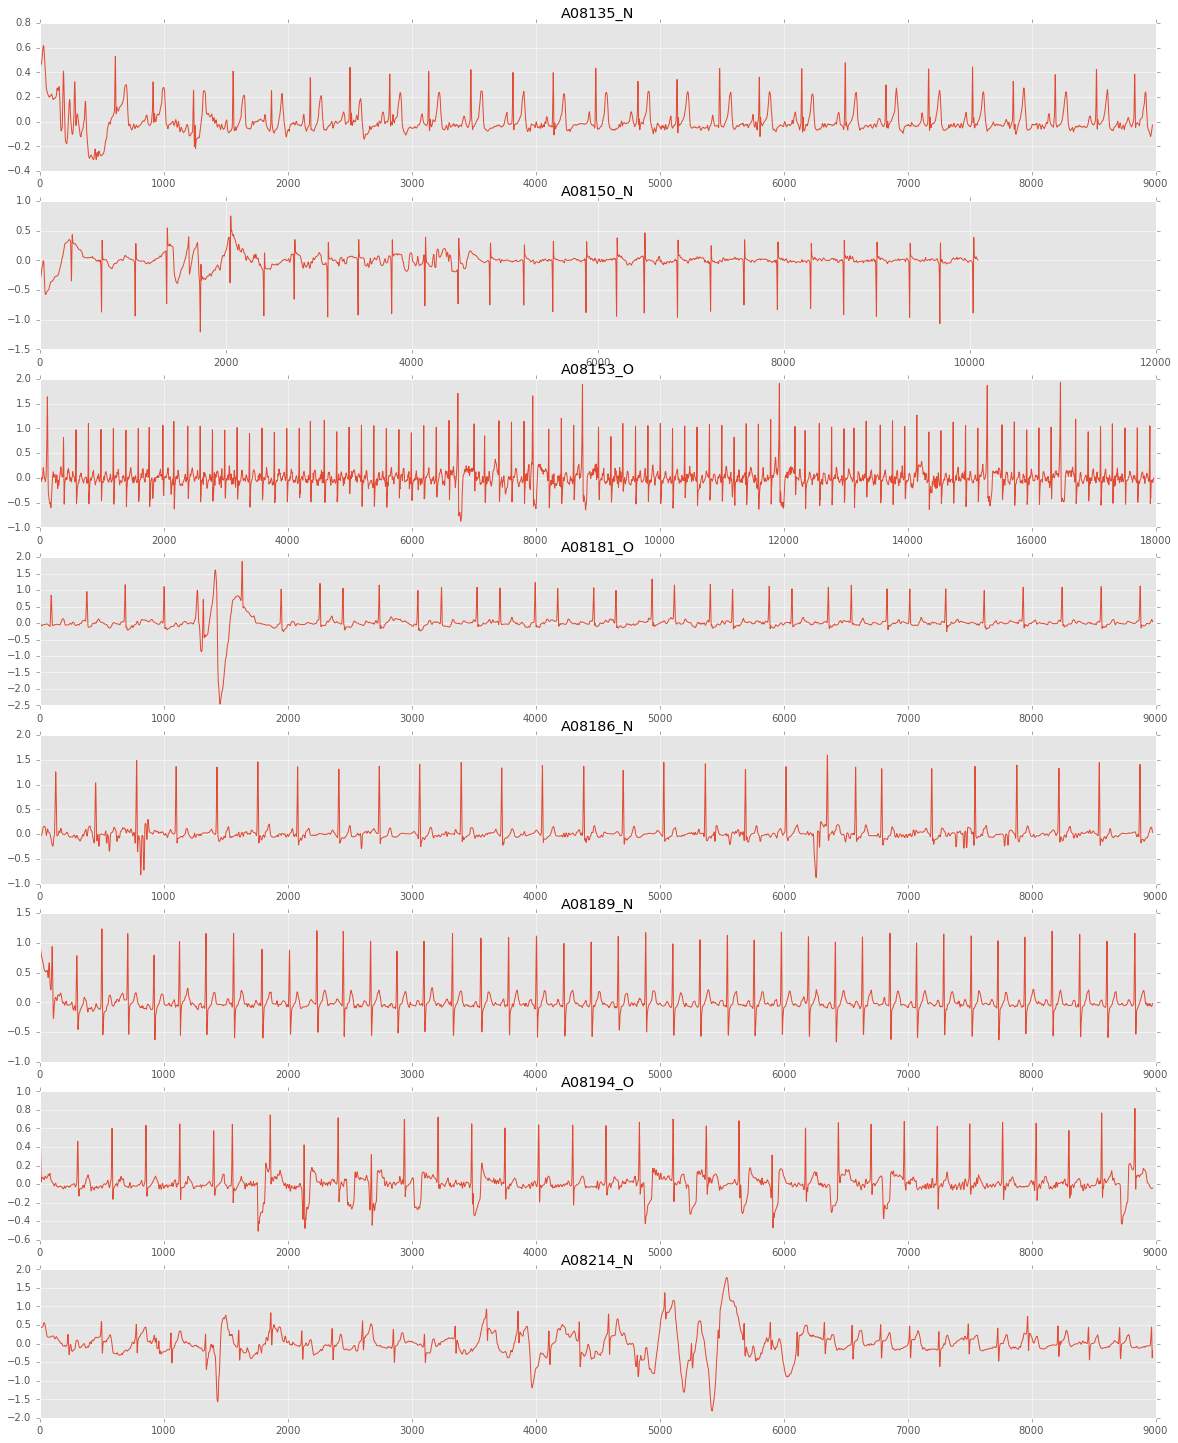

In [21]:
### plot data ###
%matplotlib inline
fig, ax = plt.subplots(nrows=8,ncols=1,figsize=(20,25))

for i,d in enumerate(res[:8]):
    y = list(d['res']['vals_norm'][24:])
    x = list(range(len(y)))
    ax.flatten()[i].plot(x,y)
    ax.flatten()[i].set_title(d['file']+'_'+d['label'])
    
plt.show()

### Vanilla statistics based

- summarize each signal by its mean r-peak and mean rr-interval 
- generate a distribution of each of the above datasets (so you get 2 dist overall)
- use the same function as above


### Multiclass classification
- assemble a vector for each signal and label them
- feed into a multiclass classifier

### Deep learning
- generate images of each signal and feed into deep learning classifier

## Statistics approach

### 1) Collecting r-peak and rr_intervals distribution

In [22]:
%%time
import functools
def get_rpeak_vals(d):
    vals = list(map(lambda i:d['res']['vals_norm'][i],d['res']['rpeaks']))
    return np.mean(vals)

def get_rr_intervals(d):
    r_peaks_seconds = list(map(lambda x:x/300,d['res']['rpeaks']))
    rr_intervals = list(map(lambda x,y:y-x,r_peaks_seconds[:-1],r_peaks_seconds[1:]))
    return np.mean(rr_intervals)

r_peaks = list(map(lambda x:get_rpeak_vals(x),res))
rr_intervals = list(map(lambda x:get_rr_intervals(x),res))

CPU times: user 806 ms, sys: 43.9 ms, total: 850 ms
Wall time: 849 ms


In [23]:
### casting data into DFs for downstream analysis
r_peaks_df = pd.DataFrame(r_peaks,columns=['r_peak_mean'])
r_peaks_df = r_peaks_df.reset_index()

rr_intervals_df = pd.DataFrame(rr_intervals,columns=['rr_interval_mean'])
rr_intervals_df = rr_intervals_df.reset_index()

In [24]:
def get_moving_average(d,window_size):
    window = np.ones(window_size)/float(window_size)
    result = np.convolve(d,window,'same') # for same number of moving avg points
    return result


def get_anomalies(d,window_size,sigma=1):
    moving_avg = get_moving_average(d, window_size)
    residuals = np.subtract(d,moving_avg)
    
    #calc mean and std of residuals
    res_mean, res_std = np.mean(residuals),np.std(residuals)
    print ('Vanilla:',res_mean, res_std)
    
    #collect a list of points in the original signal more than 1 std away from residuals
    anomalies = [(i,point) for i,avg,point in zip(range(len(residuals)),moving_avg,d)
                           if point >(avg+(sigma*res_std)) or point <(avg-(sigma*res_std))]
    return {'vals':d,'anomalies':anomalies,'moving_avg':moving_avg}


def get_anomalies_rolling(d,window_size,sigma=1):
    moving_avg = get_moving_average(d, window_size)
    residuals = np.subtract(d,moving_avg)
    
    #calc mean and std of residuals (rolling vals using pandas)
    residuals_df = pd.DataFrame(residuals)
    res_mean, res_std = residuals_df.rolling(window_size).mean(),residuals_df.rolling(window_size).std()
    testing_std_as_df = pd.DataFrame(res_std)
    rolling_std = testing_std_as_df.replace(np.nan,
                                  testing_std_as_df.ix[window_size - 1]).round(3).iloc[:,0].tolist()
    
    #collect a list of points in the original signal more than `sigma` std away from residuals
    anomalies = [(i,point) for i,avg,point,res_i in zip(range(len(residuals)),moving_avg,d,rolling_std)
                           if point >(avg+(sigma*res_i)) or point <(avg-(sigma*res_i))]
    
    return {'vals':d,'anomalies':anomalies,'moving_avg':moving_avg}

### 3) Test with a single signal and plot results

Vanilla: 0.00934523809524 0.0672618952802


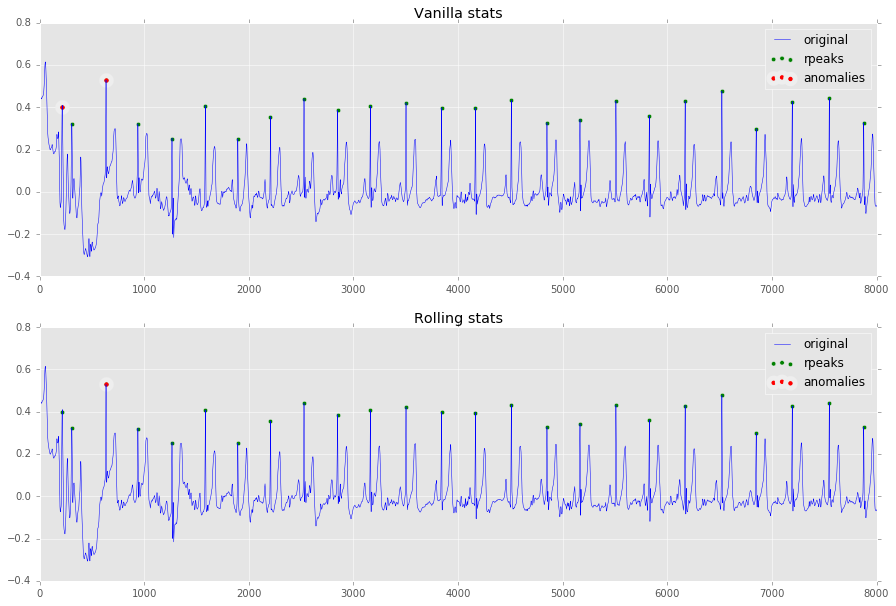

In [29]:
### prep data to be fed into anomaly detector ###
r_vals = [res[0]['res']['vals_norm'][i] for i in res[0]['res']['rpeaks'] ]
rpeaks = pd.DataFrame(list(zip(r_vals,res[0]['res']['rpeaks'])),columns=['point_vals','occ'])
d = r_vals

# get anomalies with vanilla mean and std
results = get_anomalies(d,3,2)
anomalies = pd.DataFrame(results['anomalies'],columns=['index','point_vals'])
ano = pd.merge(anomalies,rpeaks,on='point_vals',how='inner')

# get anomalies with rolling mean and std
results_rolling = get_anomalies_rolling(d,10,2)
anomalies_rolling = pd.DataFrame(results_rolling['anomalies'],columns=['index','point_vals'])
ano_rolling = pd.merge(anomalies_rolling,rpeaks,on='point_vals',how='inner')

## plot results
fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(15,10))
plt.style.use('ggplot')
axes = ax.flatten()

axes[0].plot(list(range(len(res[0]['res']['vals_norm']))),list(res[0]['res']['vals_norm']),linewidth=0.5,c='blue',label='original')
axes[0].scatter(x=rpeaks['occ'],y=rpeaks['point_vals'],c='green',marker='o',label='rpeaks')
axes[0].scatter(x=ano['occ'],y=ano['point_vals'],c='red',marker='o',label='anomalies',linewidth=10)
axes[0].set_title('Vanilla stats')
axes[0].set_xlim([0,8000])
axes[0].legend()

axes[1].plot(list(range(len(res[0]['res']['vals_norm']))),list(res[0]['res']['vals_norm']),linewidth=0.5,c='blue',label='original')
axes[1].scatter(x=rpeaks['occ'],y=rpeaks['point_vals'],c='green',marker='o',label='rpeaks')
axes[1].scatter(x=ano_rolling['occ'],y=ano_rolling['point_vals'],c='red',marker='o',label='anomalies',linewidth=10)
axes[1].set_title('Rolling stats')
axes[1].set_xlim([0,8000])
axes[1].legend()

### 4) Feed distributions in to check anomalies

- Checking R-peak distribution

In [30]:
# get anomalies with vanilla mean and std
results = get_anomalies(r_peaks,3,3)
anomalies = pd.DataFrame(results['anomalies'],columns=['index','r_peak_mean'])

# get anomalies with rolling mean and std
results_rolling = get_anomalies_rolling(r_peaks,3,2)
anomalies_rolling = pd.DataFrame(results_rolling['anomalies'],columns=['index','r_peak_mean'])


Vanilla: 2.74855221789e-05 0.309115001938


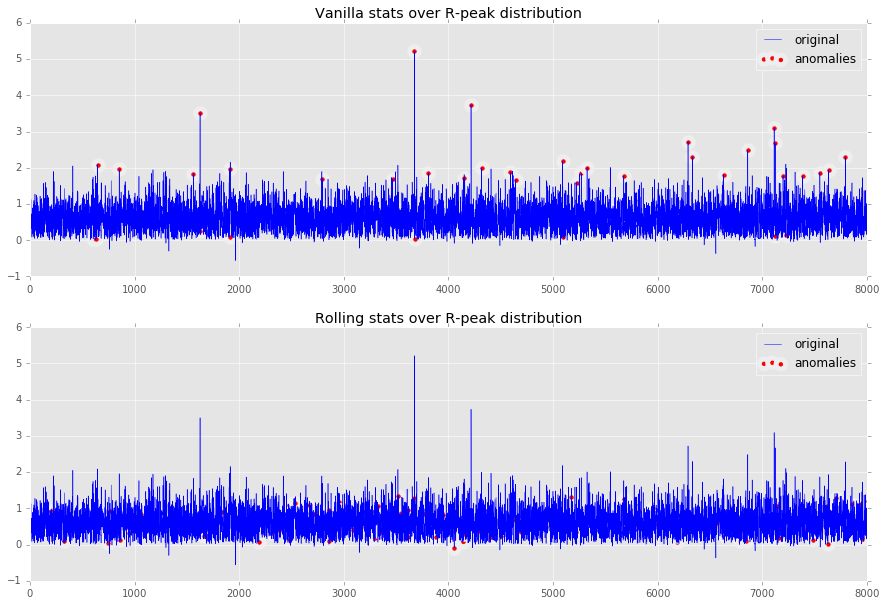

In [33]:
## plot results
fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(15,10))
plt.style.use('ggplot')
axes = ax.flatten()

axes[0].plot(list(range(len(r_peaks))),list(r_peaks),linewidth=0.5,c='blue',label='original')
axes[0].scatter(x=list(anomalies['index']),y=list(anomalies['r_peak_mean']),c='red',marker='o',label='anomalies',linewidth=10)
axes[0].set_title('Vanilla stats over R-peak distribution')
axes[0].set_xlim([0,8000])
axes[0].legend()

axes[1].plot(list(range(len(r_peaks))),list(r_peaks),linewidth=0.5,c='blue',label='original')
axes[1].scatter(x=list(anomalies_rolling['index']),y=list(anomalies_rolling['r_peak_mean']),c='red',marker='o',label='anomalies',
                linewidth=10)
axes[1].set_title('Rolling stats over R-peak distribution')
axes[1].set_xlim([0,8000])
axes[1].legend()

In [49]:
#### Make labelled data easy to consume ####
ref_data = pd.DataFrame(list(map(lambda x:x['doc']['label'],data_dump)),columns=['label'])
ref_data = ref_data.reset_index()

labels_count = ref_data.groupby('label').count()
labels_count = labels_count.reset_index()
labels_count

,label,index
0,A,771
1,N,5153
2,O,2557
3,~,46


-  Evaluate

In [48]:
classified_data = pd.merge(anomalies,ref_data,on='index')
classified_count = classified_data.groupby('label')['index'].count()
classified_count = classified_count.reset_index()
classified_count = pd.merge(classified_count,labels_count,on='label')
print ('Vanilla:\n',classified_count)

print ('\n')
classified_data = pd.merge(anomalies_rolling,ref_data,on='index')
classified_count = classified_data.groupby('label')['index'].count()
classified_count = classified_count.reset_index()
classified_count = pd.merge(classified_count,labels_count,on='label')
print ('Rolling:\n',classified_count)

Vanilla:
   label  index_x  index_y
0     A        2      771
1     N       29     5153
2     O       11     2557
3     ~        3       46


Rolling:
   label  index_x  index_y
0     A       19      771
1     N       94     5153
2     O       44     2557


Vanilla: 6.98936209667e-05 0.160620279511


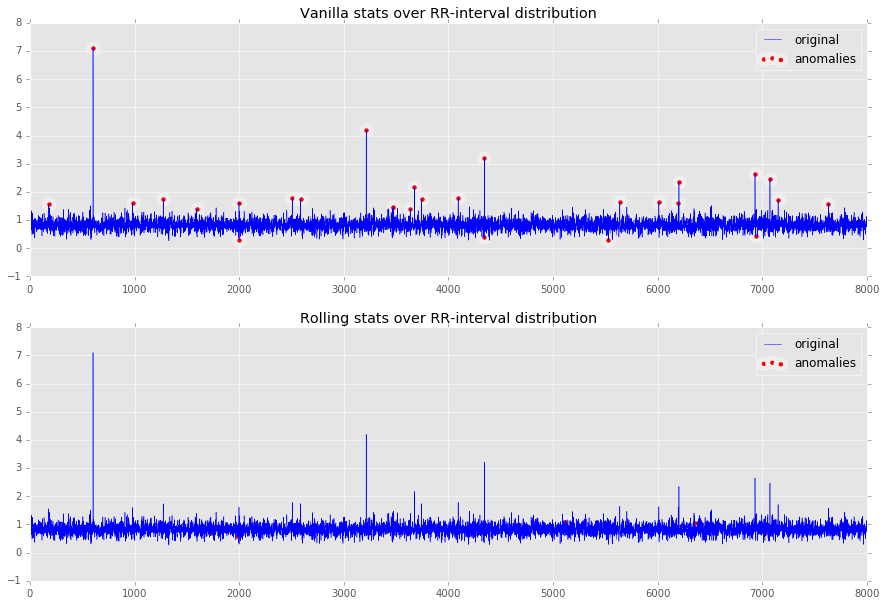

In [51]:
# get anomalies with vanilla mean and std
results = get_anomalies(rr_intervals,3,3)
anomalies = pd.DataFrame(results['anomalies'],columns=['index','r_peak_mean'])

# get anomalies with rolling mean and std
results_rolling = get_anomalies_rolling(rr_intervals,3,3)
anomalies_rolling = pd.DataFrame(results_rolling['anomalies'],columns=['index','r_peak_mean'])

## plot results
fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(15,10))
plt.style.use('ggplot')
axes = ax.flatten()

axes[0].plot(list(range(len(rr_intervals))),list(rr_intervals),linewidth=0.5,c='blue',label='original')
axes[0].scatter(x=list(anomalies['index']),y=anomalies['r_peak_mean'],c='red',marker='o',label='anomalies',linewidth=10)
axes[0].set_title('Vanilla stats over RR-interval distribution')
axes[0].set_xlim([0,8000])
axes[0].legend()

axes[1].plot(list(range(len(rr_intervals))),list(rr_intervals),linewidth=0.5,c='blue',label='original')
axes[1].scatter(x=list(anomalies_rolling['index']),y=anomalies_rolling['r_peak_mean'],c='red',marker='o',label='anomalies',linewidth=10)
axes[1].set_title('Rolling stats over RR-interval distribution')
axes[1].set_xlim([0,8000])
axes[1].legend()

- Evaluate RR distribution

In [52]:
classified_data = pd.merge(anomalies,ref_data,on='index')
classified_count = classified_data.groupby('label')['index'].count()
classified_count = classified_count.reset_index()
classified_count = pd.merge(classified_count,labels_count,on='label')
print ('Vanilla:\n',classified_count)

print ('\n')
classified_data = pd.merge(anomalies_rolling,ref_data,on='index')
classified_count = classified_data.groupby('label')['index'].count()
classified_count = classified_count.reset_index()
classified_count = pd.merge(classified_count,labels_count,on='label')
print ('Rolling:\n',classified_count)

Vanilla:
   label  index_x  index_y
0     A        4      771
1     N        8     5153
2     O       26     2557
3     ~        2       46


Rolling:
   label  index_x  index_y
0     A        3      771
1     N       38     5153
2     O        7     2557
3     ~        1       46


## Use spark ML for multiclass classification

In [53]:
#### Classification metrics ####
def calc_metrics(results,label_col,prediction_col):
    metrics = {}
    metrics['tp_0'] = results.filter((results[label_col]==0)&(results[prediction_col]==0)).count()
    metrics['fn_0'] = results.filter((results[label_col]==0)&(results[prediction_col]==1)).count()
    metrics['tn_0'] = results.filter((results[label_col]==1)&(results[prediction_col]==1)).count()
    metrics['fp_0'] = results.filter((results[label_col]==1)&(results[prediction_col]==0)).count()
    
    metrics['tp_1'] = results.filter((results[label_col]==1)&(results[prediction_col]==1)).count()
    metrics['fn_1'] = results.filter((results[label_col]==1)&(results[prediction_col]==0)).count()
    metrics['tn_1'] = results.filter((results[label_col]==0)&(results[prediction_col]==0)).count()
    metrics['fp_1'] = results.filter((results[label_col]==0)&(results[prediction_col]==1)).count()
    
    return metrics
        
### calc precision & recall ###
def precision_recall(results,label_col,prediction_col):
    items = calc_metrics(results,label_col,prediction_col)
    pre_0 = items['tp_0']/float((items['tp_0']+items['fp_0'])+1)
    pre_1 = items['tp_1']/float((items['tp_1']+items['fp_1'])+1)
    
    recall_0 = items['tp_0']/float((items['tp_0']+items['fn_0'])+1)
    recall_1 = items['tp_1']/float((items['tp_1']+items['fn_1'])+1)
    
    return {'pre_0':pre_0, 'recall_0':recall_0,'pre_1':pre_1,'recall_1':recall_1}

In [54]:
#### Classification metrics multi ####
def calc_metrics_multi(results,label_col,prediction_col):
    metrics = {}
    metrics['tp_0'] = results.filter((results[label_col]==0)&(results[prediction_col]==0)).count()
    metrics['fn_0'] = results.filter((results[label_col]==0)&(results[prediction_col]!=0)).count()
    metrics['tn_0'] = results.filter((results[label_col]!=0)&(results[prediction_col]!=0)).count()
    metrics['fp_0'] = results.filter((results[label_col]!=0)&(results[prediction_col]==0)).count()
    
    metrics['tp_1'] = results.filter((results[label_col]==1)&(results[prediction_col]==1)).count()
    metrics['fn_1'] = results.filter((results[label_col]==1)&(results[prediction_col]!=1)).count()
    metrics['tn_1'] = results.filter((results[label_col]!=1)&(results[prediction_col]!=1)).count()
    metrics['fp_1'] = results.filter((results[label_col]!=1)&(results[prediction_col]==1)).count()
    
    metrics['tp_2'] = results.filter((results[label_col]==2)&(results[prediction_col]==2)).count()
    metrics['fn_2'] = results.filter((results[label_col]==2)&(results[prediction_col]!=2)).count()
    metrics['tn_2'] = results.filter((results[label_col]!=2)&(results[prediction_col]!=2)).count()
    metrics['fp_2'] = results.filter((results[label_col]!=2)&(results[prediction_col]==2)).count()
    
    metrics['tp_3'] = results.filter((results[label_col]==3)&(results[prediction_col]==3)).count()
    metrics['fn_3'] = results.filter((results[label_col]==3)&(results[prediction_col]!=3)).count()
    metrics['tn_3'] = results.filter((results[label_col]!=3)&(results[prediction_col]!=3)).count()
    metrics['fp_3'] = results.filter((results[label_col]!=3)&(results[prediction_col]==3)).count()
    
    
    return metrics
        
### calc precision & recall ###
def precision_recall_multi(results,label_col,prediction_col):
    items = calc_metrics_multi(results,label_col,prediction_col)
    pre_0 = items['tp_0']/float((items['tp_0']+items['fp_0'])+1)
    pre_1 = items['tp_1']/float((items['tp_1']+items['fp_1'])+1)
    pre_2 = items['tp_2']/float((items['tp_2']+items['fp_2'])+1)
    pre_3 = items['tp_3']/float((items['tp_3']+items['fp_3'])+1)
    
    recall_0 = items['tp_0']/float((items['tp_0']+items['fn_0'])+1)
    recall_1 = items['tp_1']/float((items['tp_1']+items['fn_1'])+1)
    recall_2 = items['tp_2']/float((items['tp_2']+items['fn_2'])+1)
    recall_3 = items['tp_3']/float((items['tp_3']+items['fn_3'])+1)
    
    return {'pre_0':pre_0,'recall_0':recall_0,
            'pre_1':pre_1,'recall_1':recall_1,
            'pre_2':pre_2,'recall_2':recall_2,
            'pre_3':pre_3,'recall_3':recall_3}

In [56]:
### read and prep data ###
import pyspark.sql.functions as F 

#make dataframe
r_peak_data = list(map(lambda x,l:(x['res']['heart_rate'],len(x['res']['heart_rate']),l),res,ref_data['label']))
d = pd.DataFrame(r_peak_data,columns=['features','count','label'])
d = d[d['count']>0]
r_peak_records = d.to_records(index=False)

#value imputation for time series
rows = []
hr_len = 35
for row in r_peak_data:
    row_len = row[1]
    try:
        temp = [float(row[0][i]) if row_len>i else float(row[0][i%(row_len-1)]) for i in range(hr_len)]
        t = tuple(temp)+(row[1],row[2])
        rows.append(t)
    except:
        pass

raws = list(filter(lambda x:len(x[0])>35,r_peak_data))
    
columns = [str(i)+'_feature' for i in range(hr_len)]+['count','label']
df = spark.createDataFrame(rows,schema=columns)


#define transformers
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

stringIndexer = StringIndexer(inputCol='label',outputCol='indexed')
encoder = OneHotEncoder(inputCol='indexed',outputCol='encoded')
assembler = VectorAssembler(inputCols=columns[:-2],outputCol='features')

#apply transformers to your data
indexed = stringIndexer.fit(df).transform(df)
assembled = assembler.transform(indexed)
dataset = assembled.select('features','label','count','indexed')
dataset_copy = dataset

#split data into test and train
dataset = dataset.filter(dataset.indexed.isin([0.0,2.0]))
dataset = dataset.withColumn('indexed',F.when(dataset.indexed==2.0,1.0).otherwise(0.0))
train_df, test_df = dataset.randomSplit([0.7,0.3])

### Decision Tree classifier

In [57]:
# define tree model and get predictions
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(labelCol='indexed',featuresCol='features',maxDepth=8)
dt_model = dt.fit(train_df)

predictions = dt_model.transform(test_df)
print ('Precision/Recall Tree classifier ')
precision_recall(predictions,'indexed','prediction')

Precision/Recall Tree classifier 


{'pre_0': 0.9295774647887324,
 'pre_1': 0.8,
 'recall_0': 0.9837977965003241,
 'recall_1': 0.46511627906976744}

### Logistic regression classifier

In [58]:
# define LR model and get predictions
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(labelCol='indexed',featuresCol='features',regParam=0.5,maxIter=80)
lr_model = lr.fit(train_df)

predictions_lr = lr_model.transform(test_df)
print ('Precision/Recall LR classifier ')
precision_recall(predictions_lr,'indexed','prediction')

Precision/Recall LR classifier 


{'pre_0': 0.9085545722713865,
 'pre_1': 0.9523809523809523,
 'recall_0': 0.9980557355800389,
 'recall_1': 0.27906976744186046}

In [59]:
train_df.select('label','indexed').distinct().show()

+-----+-------+
|label|indexed|
+-----+-------+
|    A|    1.0|
|    N|    0.0|
+-----+-------+



### GBT

In [60]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


# Train a GBT model.
gbt = GBTClassifier(labelCol="indexed", featuresCol="features", maxIter=10)
gbt_model = gbt.fit(train_df)
results_gbt = gbt_model.transform(test_df)
precision_recall(results_gbt,'indexed','prediction')

{'pre_0': 0.9231699939503932,
 'pre_1': 0.8380952380952381,
 'recall_0': 0.9889825016202204,
 'recall_1': 0.40930232558139534}

### K-means clustering 

In [61]:
from pyspark.ml.clustering import KMeans
kmeans = KMeans(k=4,maxIter=10,seed=1,tol=0.001)
model = kmeans.fit(dataset_copy.select('features'))

# Evaluate clustering by computing Within Set Sum of Squared Errors.
wssse = model.computeCost(dataset_copy)
print("Within Set Sum of Squared Errors = " + str(wssse))

# Shows the result.
centers = model.clusterCenters()
result = model.transform(dataset_copy)

precision_recall_multi(result,'indexed','prediction')

Within Set Sum of Squared Errors = 39594617.065172955


{'pre_0': 0.6713739335098559,
 'pre_1': 0.41453982985305493,
 'pre_2': 0.477124183006536,
 'pre_3': 0.0022682166146867026,
 'recall_0': 0.4427629025999224,
 'recall_1': 0.21003134796238246,
 'recall_2': 0.18911917098445596,
 'recall_3': 0.1702127659574468}

### One v/s all - Logistic regression ###

In [62]:
from pyspark.ml.classification import LogisticRegression, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# instantiate the base classifier.
lr = LogisticRegression(maxIter=10, tol=1E-6, fitIntercept=True,featuresCol='features',labelCol='indexed')

# instantiate the One Vs Rest Classifier.
ovr = OneVsRest(classifier=lr, featuresCol='features',labelCol='indexed')

# split dataset and train the multiclass model.
train_df, test_df = dataset_copy.select(['features','indexed']).randomSplit([0.7,0.3])
ovrModel = ovr.fit(train_df)

# score the model on test data.
predictions = ovrModel.transform(test_df)

# obtain evaluator.
evaluator = MulticlassClassificationEvaluator(metricName="f1",labelCol='indexed')

# compute the classification error on test data.
f1 = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - f1))


print ('Precision recall:\n',precision_recall_multi(predictions,'indexed','prediction'))

Test Error = 0.508866
Precision recall:
 {'recall_1': 0.04980340760157274, 'pre_0': 0.620016963528414, 'recall_3': 0.0, 'recall_2': 0.05454545454545454, 'recall_0': 0.9812080536912752, 'pre_2': 0.32432432432432434, 'pre_1': 0.40860215053763443, 'pre_3': 0.0}


### One v/s All Decision Tree

In [63]:
from pyspark.ml.classification import DecisionTreeClassifier, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# instantiate the base classifier.
dt = DecisionTreeClassifier(labelCol='indexed',featuresCol='features',maxDepth=20,impurity='entropy')
# instantiate the One Vs Rest Classifier.
ovr = OneVsRest(classifier=dt, featuresCol='features',labelCol='indexed')

# split dataset and train the multiclass model.
train_df, test_df = dataset_copy.select(['features','indexed']).randomSplit([0.7,0.3])
ovrModel = ovr.fit(train_df)

# score the model on test data.
predictions = ovrModel.transform(test_df)

# obtain evaluator.
evaluator = MulticlassClassificationEvaluator(metricName="f1",labelCol='indexed')

# compute the classification error on test data.
f1 = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - f1))


print ('Precision recall:\n',precision_recall_multi(predictions,'indexed','prediction'))

Test Error = 0.405703
Precision recall:
 {'recall_1': 0.3394736842105263, 'pre_0': 0.695356738391846, 'recall_3': 0.0, 'recall_2': 0.22119815668202766, 'recall_0': 0.8170326014637392, 'pre_2': 0.3076923076923077, 'pre_1': 0.45422535211267606, 'pre_3': 0.0}
